In [1]:
# imports
from random import randint
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model, Input

import tensorflow_datasets as tfds
from tqdm import trange

# For probability output
import tensorflow_probability as tfp

# import my_dataset
import matplotlib.pyplot as plt
data_dir='/gpfsscratch/rech/qrc/commun/tensorflow_datasets'

In [2]:
# functions

def sed_model():
    """ Creates a small fully connected network
    """
    sed_input = Input(shape=(143,))
    x = tfkl.Dense(16, activation='relu')(sed_input)
    x = tfkl.Dense(32, activation='relu')(x)
    x = tfkl.Dense(64, activation='relu')(x)
    x = tfkl.Dense(128, activation='relu')(x)
    
    sed_output = tfkl.Dense(10, activation='relu')(x)
    sed_model = Model(sed_input, sed_output, name='sed_encoder')
    return sed_model


def img_model():
    """ Creates a small fully connected network
    """
    img_input = Input(shape=(128, 128, 4))
    x = tfkl.Conv2D(16, 3, strides=2, activation='relu', padding='same')(img_input)
    x = tfkl.Conv2D(32, 3, strides=2, activation='relu', padding='same')(x)
    x = tfkl.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
    x = tfkl.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
    x = tfkl.Flatten()(x)
    x = tfkl.Dense(128, activation='relu')(x)
    x = tfkl.Dense(10, activation='relu')(x)
    img_output = tfkl.Dense(10, activation='relu')(x)
    img_model = Model(img_input, img_output, name='img_encoder')
    return img_model


sed_encoder = sed_model()
sed_encoder.summary()
img_encoder = img_model()
img_encoder.summary()

sed_inputs = Input(shape=(143,), name='sed_inputs')
img_inputs = Input(shape=(128, 128, 4))

sed_code = sed_encoder(sed_inputs)
img_code = img_encoder(img_inputs)

combined = tf.concat([sed_code, img_code], axis=1)
#combinatory_output = tfkl.Dense(1, activation='softplus')(combined)

num_components = 16
event_shape = [1]

params = tfkl.Dense(tfp.layers.MixtureNormal.params_size(num_components, event_shape),
                    activation='softplus')(combined)
combinatory_output = tfp.layers.MixtureNormal(num_components, event_shape)(params)
#combinatory_output = tfkl.Dense(1, activation='softplus')(combined)

model = Model(inputs=[sed_inputs, img_inputs], outputs=combinatory_output)
model.summary()

2021-12-09 18:07:04.118115: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 18:07:04.758773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2021-12-09 18:07:05.234158: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "sed_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 143)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                2304      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 14,570
Trainable params: 14,570
Non-trainable params: 0
___________________________________________________

In [3]:
#def to_mag(x):
#    return (-2.5*tf.math.log(x)+8.90)
def to_app_mag(abs_mag):
    return abs_mag + 5*(np.log10(20e6)-1)

def preprocessing(example):
    # Magic constants (from mergers_kin_scripts)
    std_noiseless_griz = 9.816043
    stellar_light_compression = 3.0
    img0 = example['noiseless_griz']
    img0 = tf.where(tf.math.is_nan(img0), tf.zeros_like(img0), img0)
    img0 = tf.where(tf.math.is_inf(img0), tf.zeros_like(img0), img0)
    img0 = tf.math.asinh(img0 / tf.constant(std_noiseless_griz) * tf.constant(stellar_light_compression) ) / tf.constant(stellar_light_compression)

    # Convert flux to magnitude-like ; 46.0 is max value 
    sed = to_app_mag(example['sed']) / 30.
    
    return (sed, img0), example['mass_quantiles'][4]

def preprocessing_test(example):
    # Magic constants (from mergers_kin_scripts)
    std_noiseless_griz = 9.816043
    stellar_light_compression = 3.0
    
    img0 = example['noiseless_griz']
    img0 = tf.where(tf.math.is_nan(img0), tf.zeros_like(img0), img0)
    img0 = tf.where(tf.math.is_inf(img0), tf.zeros_like(img0), img0)
    img0 = tf.math.asinh(img0 / tf.constant(std_noiseless_griz) * tf.constant(stellar_light_compression) ) / tf.constant(stellar_light_compression)
    
    # Convert flux to magnitude-like ; 46.0 is max value 
    sed = to_app_mag(example['sed']) / 30.

    return (sed, img0), example['mass_quantiles'][4], example['Mstar_Half'], example['time'], example['mass_quantiles']

def input_fn(mode='train', batch_size=32):
    """
    mode: 'train' or 'test'
    """
    def has_sfh(example):
        print(example)
        return not tf.reduce_all(example['Mstar_Half'] == 0)

    if mode == 'train':
        dataset = tfds.load('tng100', split='train[:80%]', data_dir=data_dir)
        dataset = dataset.filter(has_sfh) # adding a filtering condition to exclude empty catalogs
        dataset = dataset.map(preprocessing) # Apply data preprocessing
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
        #dataset = dataset.filter(lambda x: x['last_over_max'] > 0.9) # adding a filtering condition to gold samples
    else:
        dataset = tfds.load('tng100', split='train[80%:]', data_dir=data_dir)
        dataset = dataset.filter(has_sfh) # adding a filtering condition to exclude empty catalogs
        dataset = dataset.map(preprocessing_test) # Apply data preprocessing
    
    dataset = dataset.batch(batch_size, drop_remainder=True)

    dataset = dataset.prefetch(-1)  # fetch next batches while training current one (-1 for autotune)
    return dataset

In [4]:
def negloglik(y_true, y_pred):
    # instead of tf.keras.losses.MSE
    #print(y_pred.shape, y_true.shape)
    return -y_pred.log_prob(y_true)

model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=negloglik, metrics=['accuracy'])
label = 'img+sed_cnnproba_last-mass'
EPOCHS = 40
now = str(datetime.datetime.now())[0:16].replace('-','_').replace(' ','_').replace(':','_')
checkpoint_filepath = '/gpfsscratch/rech/qrc/commun/sfhsed/checkpoint/'+label+'/'+now
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

In [5]:
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.99

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

dset = input_fn(mode='train', batch_size=16)
history = model.fit(dset, steps_per_epoch=200, epochs=EPOCHS, callbacks=[model_checkpoint_callback, lr_decay])

{'Mstar': <tf.Tensor 'args_0:0' shape=(100,) dtype=float32>, 'Mstar_Half': <tf.Tensor 'args_1:0' shape=(100,) dtype=float32>, 'SFR_Max': <tf.Tensor 'args_2:0' shape=(100,) dtype=float32>, 'SFR_Rad': <tf.Tensor 'args_3:0' shape=(100,) dtype=float32>, 'SFR_halfRad': <tf.Tensor 'args_4:0' shape=(100,) dtype=float32>, 'last_major_merger': <tf.Tensor 'args_5:0' shape=() dtype=float32>, 'last_over_max': <tf.Tensor 'args_6:0' shape=() dtype=float32>, 'mass_quantiles': <tf.Tensor 'args_7:0' shape=(9,) dtype=float32>, 'noiseless_griz': <tf.Tensor 'args_8:0' shape=(128, 128, 4) dtype=float32>, 'object_id': <tf.Tensor 'args_9:0' shape=() dtype=int32>, 'sed': <tf.Tensor 'args_10:0' shape=(143,) dtype=float32>, 'stellar_light': <tf.Tensor 'args_11:0' shape=(512, 512) dtype=float32>, 'time': <tf.Tensor 'args_12:0' shape=(100,) dtype=float32>, 'velocity_dispersion_map': <tf.Tensor 'args_13:0' shape=(512, 512) dtype=float32>, 'velocity_map': <tf.Tensor 'args_14:0' shape=(512, 512) dtype=float32>}
Epoc

2021-12-09 18:07:20.802484: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-09 18:07:30.995411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 8966 of 10000
2021-12-09 18:07:31.564928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-12-09 18:07:32.501878: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


200/200 [==============================] - 17s 16ms/step - loss: 0.6082 - accuracy: 0.0000e+00
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.00099.
200/200 [==============================] - 2s 12ms/step - loss: 0.5660 - accuracy: 0.0000e+00
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009801.
200/200 [==============================] - 2s 12ms/step - loss: 0.5644 - accuracy: 0.0000e+00
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009702990000000001.
200/200 [==============================] - 3s 14ms/step - loss: 0.5636 - accuracy: 0.0000e+00
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 0.0009605960099999999.
200/200 [==============================] - 3s 13ms/step - loss: 0.5629 - accuracy: 0.0000e+00
Epoch 6/40

Epoch 00006: LearningRateScheduler setting learning rate to 0.0009509900498999999.
200/200 [==============================] - 2s 12ms/step - loss: 0.5623 - accurac

In [ ]:
# To read the model from disk
if False:
    checkpoint_filepath = '/gpfsscratch/rech/qrc/commun/sfhsed/checkpoint/img_cnnproba_last-mass/2021_12_09_14_26'
    status = model.load_weights(checkpoint_filepath)

Text(0.5, 1.0, 'Log Likelihood Loss history')

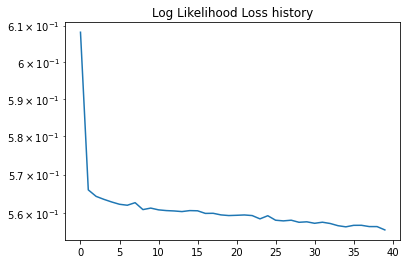

In [6]:
plt.figure()
plt.plot(np.arange(len(model.history.history['loss'])), model.history.history['loss'])
plt.yscale('log')
plt.title('Log Likelihood Loss history')

In [7]:
dset_test = input_fn(mode='test', batch_size=128)

{'Mstar': <tf.Tensor 'args_0:0' shape=(100,) dtype=float32>, 'Mstar_Half': <tf.Tensor 'args_1:0' shape=(100,) dtype=float32>, 'SFR_Max': <tf.Tensor 'args_2:0' shape=(100,) dtype=float32>, 'SFR_Rad': <tf.Tensor 'args_3:0' shape=(100,) dtype=float32>, 'SFR_halfRad': <tf.Tensor 'args_4:0' shape=(100,) dtype=float32>, 'last_major_merger': <tf.Tensor 'args_5:0' shape=() dtype=float32>, 'last_over_max': <tf.Tensor 'args_6:0' shape=() dtype=float32>, 'mass_quantiles': <tf.Tensor 'args_7:0' shape=(9,) dtype=float32>, 'noiseless_griz': <tf.Tensor 'args_8:0' shape=(128, 128, 4) dtype=float32>, 'object_id': <tf.Tensor 'args_9:0' shape=() dtype=int32>, 'sed': <tf.Tensor 'args_10:0' shape=(143,) dtype=float32>, 'stellar_light': <tf.Tensor 'args_11:0' shape=(512, 512) dtype=float32>, 'time': <tf.Tensor 'args_12:0' shape=(100,) dtype=float32>, 'velocity_dispersion_map': <tf.Tensor 'args_13:0' shape=(512, 512) dtype=float32>, 'velocity_map': <tf.Tensor 'args_14:0' shape=(512, 512) dtype=float32>}


In [9]:
i = 0
truthes = []
predicted_mean = []
predicted_std = []
for ibatch, features in enumerate(dset_test):
    truth = features[1]
    truthes.append(truth)
    predict = model(features[0])
    predicted_mean.append(predict.mean())
    predicted_std.append(predict.stddev())
    i = i + 1
truthes = np.ravel(truthes)
predicted_mean = np.ravel(predicted_mean)
predicted_std = np.ravel(predicted_std)

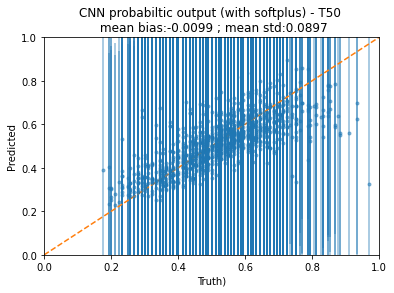

In [10]:
plt.errorbar(truthes, predicted_mean, predicted_std, marker='.', ls='', alpha=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], '--')
plt.title(f'CNN probabiltic output (with softplus) - T50 \n mean bias:{np.mean(predicted_mean-truthes):.4f} ; mean std:{np.std(predicted_mean-truthes):.4f}')
plt.xlabel('Truth)')
plt.ylabel('Predicted')
#zoom_axes = plt.axes([0.6, 0.2, 0.25, 0.25])
#zoom_axes.errorbar(truthes, predicted_mean - truthes, predicted_std, marker='.', ls='', alpha=0.5)
#zoom_axes.plot([0, 2.5], [0, 2.5], '--')
#zoom_axes.axhline(0.0, color='orange', ls='--')
#zoom_axes.set_xlim(0, 2.5)
#zoom_axes.set_ylim(-2.5, 2.5)
#zoom_axes.grid()
plt.savefig('cnn_proba_softplus_image+sed_t50_predicted_vs_truth.png', dpi=144)

In [ ]:
plt.errorbar(truthes, predicted_mean - truthes, predicted_std, marker='.', ls='', alpha=0.5)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.plot([0, 3], [0, 3], '--')
plt.title('CNN probabiltic output (with softplus) - Final Mass')
plt.xlabel('Truth $\log_10(M/M_\odot$)')
plt.ylabel('Predicted $\log_10(M/M_\odot$)')
#plt.savefig('cnn_proba_softplus_image_final_mass_predicted_vs_truth_zoom.pdf')

In [ ]:
plt.axes?